In [55]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from advectionGP.constraints import NonNegConstraint
from advectionGP.sensors import FixedSensorModel 
from advectionGP.kernels import meshgridndim
from advectionGP.kernels import EQ 
from advectionGPdatasets.ode_modelsample import ODEModelSample
from advectionGP.models.mesh_1d_ode_model import AdjointSecondOrderODEModel as ODEModel

# Generate Results

In [56]:
seed = 1
np.random.seed(seed)
#k_0 = -p0
#u   = p1 
#eta = p2
ds = ODEModelSample(non_neg=True,k_0=-0.01,u=0.2,eta=0.1,ls=0.5,Npoints=30)
X, Y, sourceGT, concTrain, boundary, m = ds.X, ds.Y, ds.source, ds.conc, ds.boundary, ds.m



Computing mean and covariance of Z distribution
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Sampling...
Computing inverse, for conditional distributions.
Sampling
Starting sampling loop
   21/   22 [samples]


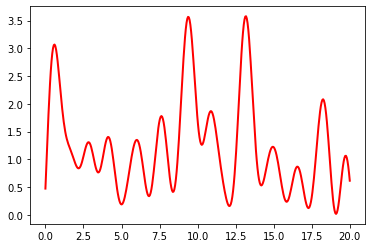

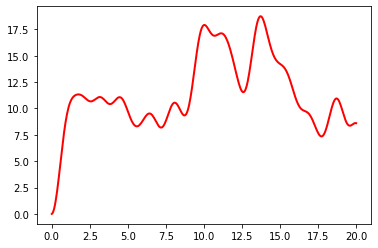

In [57]:
plt.plot(ds.m.coords[0,:],sourceGT,'r-',lw=2,label='true')
plt.figure()
plt.plot(ds.m.coords[0,:],concTrain,'r-',lw=2,label='true')

In [58]:
np.set_printoptions(precision=5,suppress=True)

In [59]:
pickle.dump([ds, X, Y, sourceGT, concTrain, boundary, m],open('synthetic_ODE_example_%d.pkl' % seed,'wb'))

In [62]:
Nsamples = 20
results = []
record = {}
ls = 0.5

uvals = np.logspace(-1.3,1.605,30)[:-1] #just removed last one!
uvals = np.r_[uvals[0::3],uvals[1::3],uvals[2::3]]
print(uvals)

for it,u in enumerate(uvals): #enumerate(np.logspace(-1.5,1/3,23)):
#for it,ls in enumerate([0.5]): #enumerate(np.logspace(-1.1,1,10)):
    print("================%0.1f [%0.5f]===============" % (it,u)) 
    np.random.seed(42)
    N_feat = 500 #Number of features used to infer the source
    k = EQ(ls, 2.0)
    res = [400]
    noiseSD = 0.1
    sensors = FixedSensorModel(X[::2],0.1)

    k_0=-0.01
    #u=0.1
    eta=0.1
    
    mTest = ODEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,k_0=k_0,u=u,eta=eta)
    regressors = mTest.computeModelRegressors() # Compute regressor matrix
    meanZ, covZ = mTest.computeZDistribution(Y[::2]) # Infers z vector mean and covariance
    
    
    concInferred_samples = []
    sourceInferred_samples = []
    sse_samples = []
    obs_samples = []
    
    mTest.sensormodel = FixedSensorModel(X[1::2],0.1)
    for jitterA in [0,1e-8,1e-7,1e-6,1e-5,1e-4,None]:
        if jitterA is None:
            break
        try:
            Zsamps = np.random.multivariate_normal(meanZ,covZ+np.eye(len(covZ))*jitterA,Nsamples)
            break
        except np.linalg.LinAlgError:
            print("Failed to invert during Non-negative sampling. Adding jitter...")
         
    
    #we just give up with this data point...
    if jitterA is None:
        print("Giving up with this configuration")
        continue
        
    for Z in Zsamps:
        sourceInferred = mTest.computeSourceFromPhi(Z) # Generates estimated source using inferred distributio
        sourceInferred_samples.append(sourceInferred)
        
        conc = mTest.computeResponse(sourceInferred)
        concInferred_samples.append(conc)
        mTest.conc = conc
        obs = mTest.computeObservations()
        #sse_samples.append(np.sum((obs-Y[1::2])**2))
        sse_samples.append(np.sum((np.mean(np.array(obs),0)-Y[1::2])**2))
        obs_samples.append(obs)
        
    ###Non-neg calculation...
    #################################################################################################
    mTest.sensormodel = FixedSensorModel(X[::2],0.1)
    concInferred_nonneg_samples = []
    sourceInferred_nonneg_samples = []
    sse_nonneg_samples = []
    obs_nonneg_samples = []
    
    for jitterB in [0,1e-8,1e-7,1e-6,1e-5,1e-4,None]:
        if jitterB is None:
            break
        try:
            nnc = NonNegConstraint(mTest,Y[::2],np.linspace(0,20,200)[:,None],thinning=10+int(20*u),burnin=50,jitter=jitterB,verbose=True)
            break
        except np.linalg.LinAlgError:
            print("Failed to invert during Non-negative sampling. Adding jitter...")

    if jitterB is None:
        print("Giving up with this configuration")
        continue

    try:
        samps = nnc.sample(Nsamples=Nsamples)
    except NoValidStartPointFoundError:
        print("NoValidStartPointFoundError!!")
        continue
    mTest.sensormodel = FixedSensorModel(X[1::2],0.1)
    for samp in samps:
        sourceInferred = mTest.computeSourceFromPhi(samp)
        sourceInferred_nonneg_samples.append(sourceInferred)

        conc = mTest.computeResponse(sourceInferred)
        concInferred_nonneg_samples.append(conc)
        mTest.conc = conc
        obs = mTest.computeObservations()
        #sse_nonneg_samples.append(np.sum((obs-Y[1::2])**2))
        sse_nonneg_samples.append(np.sum((np.mean(np.array(obs),0)-Y[1::2])**2))
        obs_nonneg_samples.append(obs)

        
    results.append([u,np.mean(sse_nonneg_samples), np.mean(sse_samples),jitterA,jitterB])
    record[u]=[mTest,regressors,meanZ,covZ,concInferred_samples,sourceInferred_samples,sse_samples,obs_samples,concInferred_nonneg_samples,sourceInferred_nonneg_samples,sse_nonneg_samples,obs_nonneg_samples]

    pickle.dump(record,open('recordODEfindparams_u_%d_seed=%d.pkl' % (it,seed),'wb'))

[ 0.05012  0.10012  0.2      0.39953  0.79812  1.59436  3.18496  6.3624
 12.70978 25.38956  0.06312  0.12609  0.25189  0.50318  1.00517  2.00798
  4.01121  8.01296 16.00701 31.97625  0.0795   0.1588   0.31723  0.63372
  1.26594  2.5289   5.05182 10.09173 20.15964]
================0.0 [0.05012]===============


Computing SS...
Inverting SS...
Computing meanZ
Done
Computing mean and covariance of Z distribution
Computing SS...
Inverting SS...
Computing meanZ
Done
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Sampling...
Computing inverse, for conditional distributions.
Sampling
Starting sampling loop
  269/  270 [samples]
================1.0 [0.10012]===============


Computing SS...
Inverting SS...
Computing meanZ
Done
Computing mean and covariance of Z distribution
Computing SS...
Inverting SS...
Computing meanZ
Done
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Sampling...
C

 6649/ 6650 [samples]
================19.0 [31.97625]===============


Computing SS...
Inverting SS...
Computing meanZ
Done
Computing mean and covariance of Z distribution
Computing SS...
Inverting SS...
Computing meanZ
Done
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Sampling...
Computing inverse, for conditional distributions.
Sampling
Starting sampling loop
13029/13030 [samples]
================20.0 [0.07950]===============


Computing SS...
Inverting SS...
Computing meanZ
Done
Computing mean and covariance of Z distribution
Computing SS...
Inverting SS...
Computing meanZ
Done
Instantiating Truncated MVN object
Computing Cholesky...
Inverting Cholesky...
Instantiation Complete
Sampling...
Computing inverse, for conditional distributions.
Sampling
Starting sampling loop
  269/  270 [samples]
================21.0 [0.15880]===============


Computing SS...
Inverting SS...
Computing meanZ
Done
Computing mean and covariance of Z d

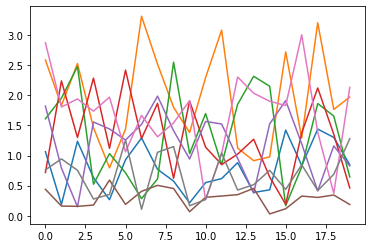

In [31]:
#plt.plot(np.array(record[sorted(record.keys())[3]][9])[:,::50]) #.sourceInferred_nonneg_samples

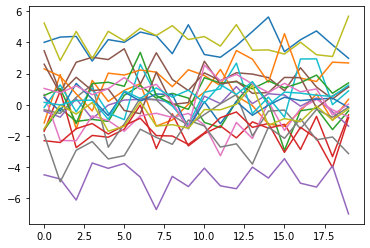

In [14]:
plt.plot(samps[:,::25])

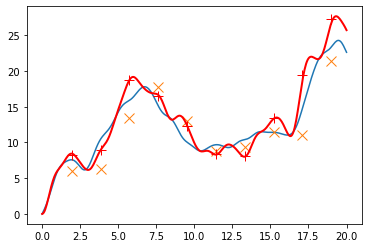

In [49]:
plt.plot(mTest.coords[0,:],conc)
plt.plot(X[1::2,0],mTest.computeObservations(),'x',markersize=10)
plt.plot(X[1::2,0],Y[1::2],'+r',markersize=10)
plt.plot(ds.m.coords[0,:],concTrain,'r-',lw=2,label='true')

In [50]:
#pickle.dump(results,open('results_done.pkl','wb'))
#pickle.dump([record,ds,X, Y, sourceGT, concTrain, boundary, m],open('record_done.pkl','wb'))

# Plot results

In [51]:
#results = pickle.load(open('results_001.pkl','rb'))
#[record,ds,X, Y, sourceGT, concTrain, boundary, m] = pickle.load(open('record.pkl','rb'))

In [32]:
results

[[0.05011872336272722, 169.4776125919033, 438.964945681522, 0, 0],
 [0.10011917018024433, 78.4282286413856, 94.1157441011467, 0, 0],
 [0.20000206639412044, 52.01181651678265, 62.62841973130751, 0, 0],
 [0.39953214244489604, 50.842274812426545, 57.02702331159369, 0, 0],
 [0.7981214180660148, 49.956967528485976, 51.495768156349186, 0, 0],
 [1.5943593275816654, 50.01588661393182, 50.8915199300926, 0, 0],
 [3.1849560830059143, 50.08290334092594, 50.69774854849517, 0, 0],
 [6.362395901093876, 50.17123524497483, 50.651684466679384, 0, 0],
 [12.709777010190866, 50.882384927813575, 51.436196792822614, 0, 0]]

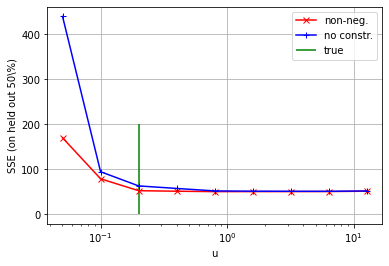

In [35]:
results = np.array(results)
results = results[np.argsort(results[:,0]),:]
plt.plot(results[:,0],results[:,1],'-xr',label='non-neg.')
plt.plot(results[:,0],results[:,2],'-+b',label='no constr.')
plt.xscale('log')
plt.grid()
plt.ylabel('SSE (on held out 50\%)')
plt.xlabel('u')
#plt.ylim([300,500])
plt.vlines(0.2,0,200,color='green',label='true')
plt.legend()
plt.savefig('temp_non_neg_estimate_u.pdf')

In [36]:
concInferred_samples[0].shape

(400,)

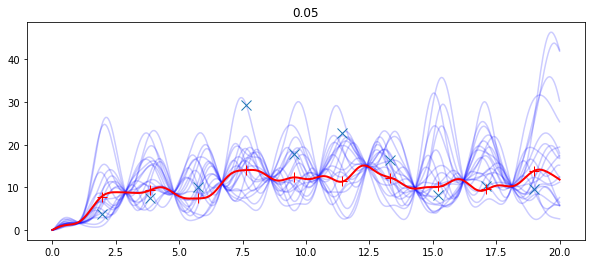

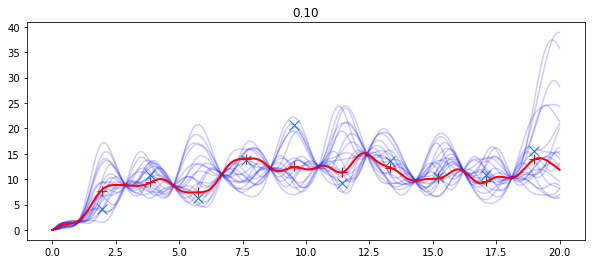

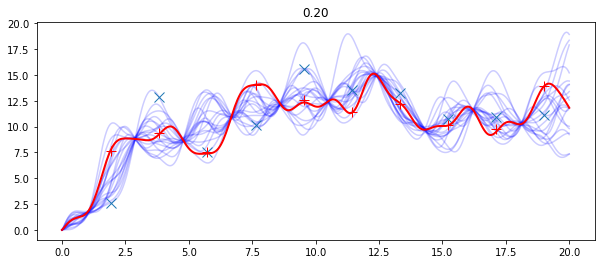

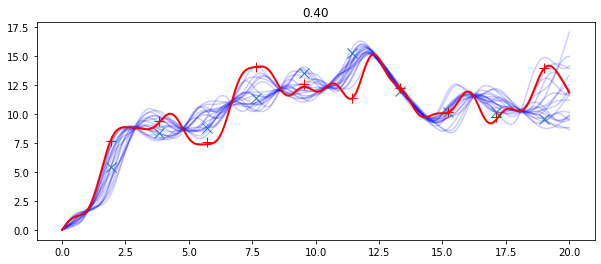

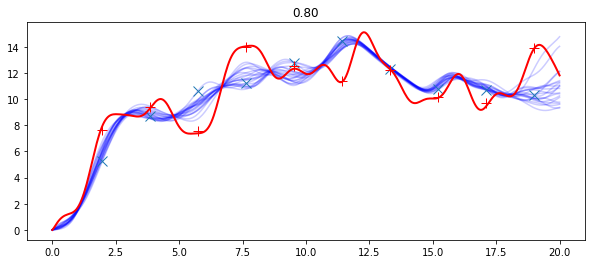

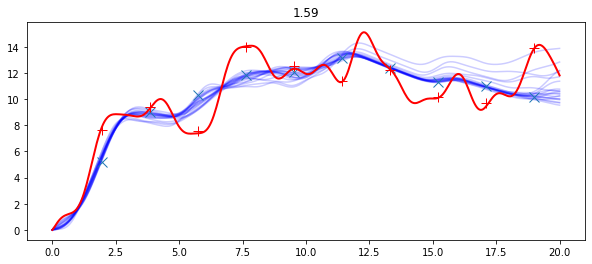

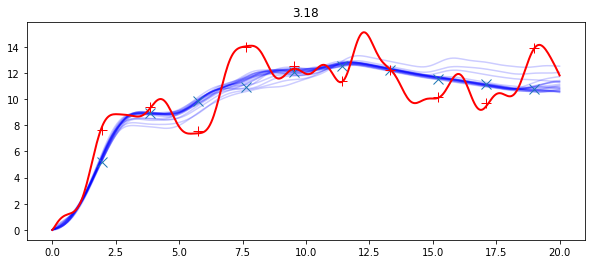

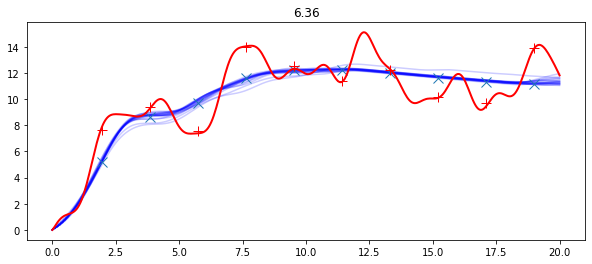

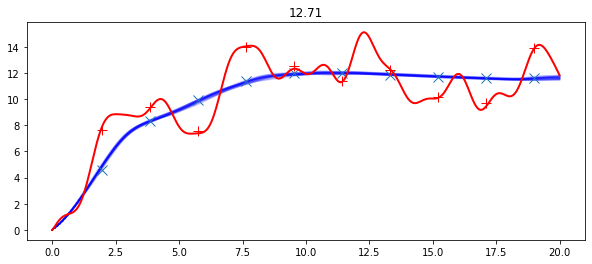

In [37]:
for v,rec in record.items():
    plt.figure(figsize=[10,4])
    mTest,regressors,meanZ,covZ,concInferred_samples,sourceInferred_samples,sse_samples,obs_samples,concInferred_nonneg_samples,sourceInferred_nonneg_samples,sse_nonneg_samples,obs_nonneg_samples = rec
    #plt.plot(mTest.coords[0,:],mTest.conc)
    plt.plot(mTest.coords[0,:],np.array(concInferred_nonneg_samples).T,'-b',alpha=0.2)
    plt.plot(X[1::2,0],mTest.computeObservations(),'x',markersize=10)
    plt.plot(X[1::2,0],Y[1::2],'+r',markersize=10)
    plt.plot(ds.m.coords[0,:],concTrain,'r-',lw=2,label='true')
    plt.title("%0.2f" % mTest.u)
    
    #plt.hist(sse_samples,np.linspace(0,1000))

In [40]:
def compute_nlpd(obs_samples,true_vals):
    nlpd = 0
    for idx in range(len(true_vals)):
        ob = np.array(obs_samples)[:,idx]
        nlpd-=norm.logpdf(true_vals[idx],np.mean(ob),np.std(ob))
    return nlpd

#v,plt.hist(ob,7)
from scipy.stats import norm
#x = np.linspace(-25,35,100)
#plt.plot(x,100*norm.pdf(x,np.mean(ob),np.std(ob)))
#plt.vlines(Y[1::2][4],0,5)

In [53]:
temp = []
print('       u  [samps   meanOfSamps    NLPD  ][NN_samps NN_meanOfSamps NN_NLPD]')
for v in sorted(record.keys())[::-1]:
    rec = record[v]
    mTest,regressors,meanZ,covZ,concInferred_samples,sourceInferred_samples,sse_samples,obs_samples,concInferred_nonneg_samples,sourceInferred_nonneg_samples,sse_nonneg_samples,obs_nonneg_samples = rec
    row = []
    row.append(v)
    row.append(np.sum((np.array(obs_samples)-Y[1::2])[:-1]**2))
    row.append(np.sum((np.mean(np.array(obs_samples),0)-Y[1::2])[:-1]**2))
    row.append(compute_nlpd(obs_samples[:-1],Y[1::2][:-1]))
    row.append(np.sum((np.array(obs_nonneg_samples)-Y[1::2])[:-1]**2))
    row.append(np.sum((np.mean(np.array(obs_nonneg_samples),0)-Y[1::2])[:-1]**2))
    row.append(compute_nlpd(obs_nonneg_samples[:-1],Y[1::2][:-1]))
    print("%9.2f [%9.1f,%9.1f,%9.1f][%9.1f,%9.1f,%9.1f]" % tuple(row))
    temp.append(row)
#sse_nonneg_samples.append(np.sum((obs-Y[1::2])**2))

       u  [samps   meanOfSamps    NLPD  ][NN_samps NN_meanOfSamps NN_NLPD]
    12.71 [    733.0,     27.4,   2123.2][    655.0,     29.0,   3494.4]
     6.36 [    760.8,     25.1,    769.1][    606.0,     24.7,    482.8]
     3.18 [    814.6,     24.3,    365.1][    641.0,     24.2,    254.0]
     1.59 [    919.3,     25.2,     91.2][    689.1,     24.1,    172.9]
     0.80 [   1040.6,     24.6,     32.1][    723.7,     24.6,    113.9]
     0.40 [   1749.1,     32.3,     19.7][    817.8,     24.9,     22.1]
     0.20 [   3165.2,     27.9,     19.9][   1214.1,     26.2,     17.0]
     0.10 [  10726.7,     28.7,     25.1][   3865.7,     36.8,     21.0]
     0.05 [  28429.9,    172.5,     29.6][   9616.5,    102.5,     25.7]


Text(0, 0.5, 'Sum Squared Error')

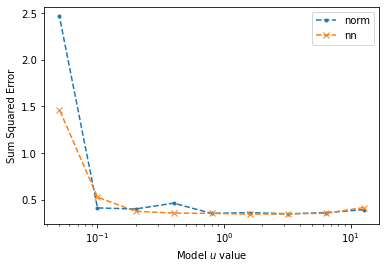

In [54]:
temp = np.array(temp)
#plt.figure(figsize=[10,10])
#plt.subplot(2,1,1)
#plt.plot(temp[:,0],temp[:,3],'.-',label='norm NLPD')
#plt.plot(temp[:,0],temp[:,6],'-x',label='nn NLPD')
plt.plot(temp[:,0],temp[:,2]/70,'.--',label='norm')
plt.plot(temp[:,0],temp[:,5]/70,'--x',label='nn')
#plt.ylim([10,160])
#plt.ylim([1000,4000])
plt.xscale('log')
#plt.vlines(0.2,0,10000)
plt.legend()
#plt.xlim([0.04,10])
plt.xlabel('Model $u$ value')
plt.ylabel('Sum Squared Error')
#plt.subplot(2,1,2)
#plt.plot(temp[:,0],temp[:,2],'.-',label='norm')
#plt.plot(temp[:,0],temp[:,4],'-x',label='nn')
#plt.ylim([50,120])
#plt.xscale('log')
#plt.vlines(0.2,0,10000)
#plt.legend()
#plt.xlim([0,12])

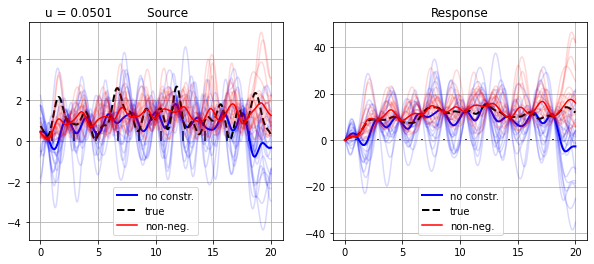

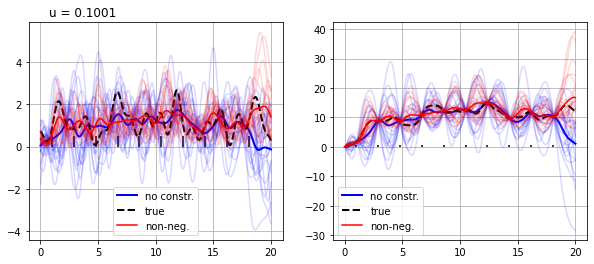

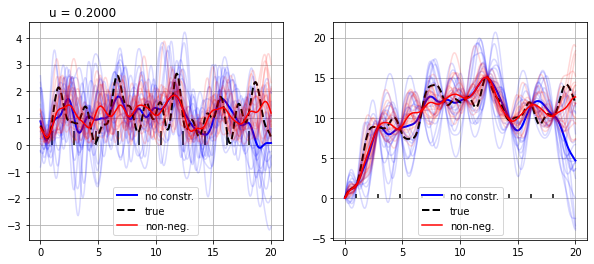

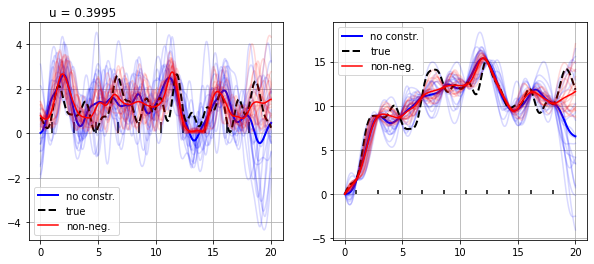

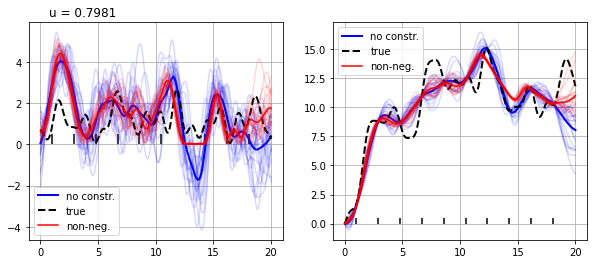

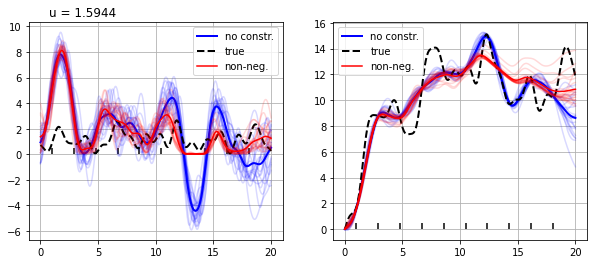

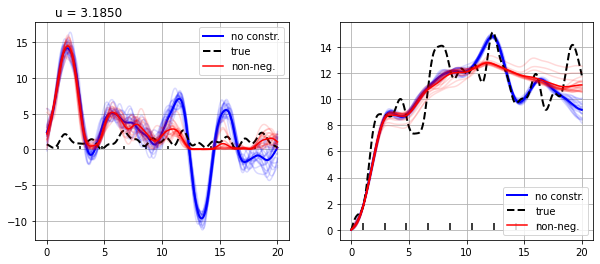

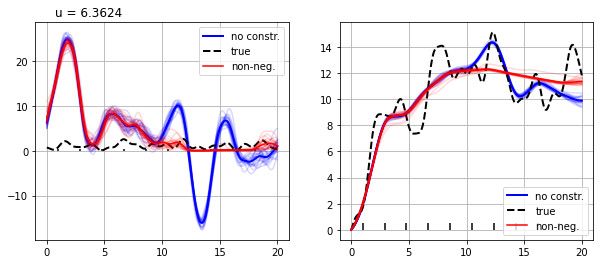

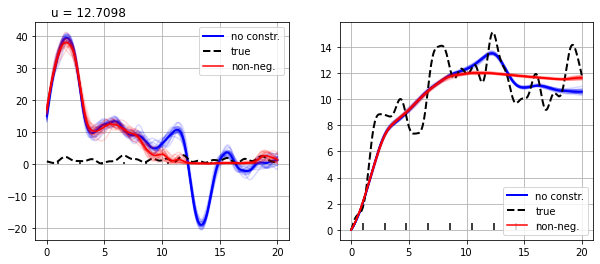

In [52]:
firstrow = True
for v in sorted(record.keys()):
    rec = record[v]
    plt.figure(figsize=[10,4])
    mTest,regressors,meanZ,covZ,concInferred_samples,sourceInferred_samples,sse_samples,obs_samples,concInferred_nonneg_samples,sourceInferred_nonneg_samples,sse_nonneg_samples,obs_nonneg_samples = rec
    plt.subplot(1,2,1)
    plt.plot(ds.m.coords[0,:],np.mean(sourceInferred_samples,0),'b-',lw=2,label='no constr.')
    plt.plot(ds.m.coords[0,:],np.array(sourceInferred_samples).T,'b-',alpha=0.15)
    #plt.fill_between(ds.m.coords[0,:],np.min(np.array(sourceInferred_samples).T,1),np.max(np.array(sourceInferred_samples).T,1),color='blue',alpha=0.2)
    plt.plot(ds.m.coords[0,:],sourceGT,'k--',lw=2,label='true')
    
    #plt.text(0,4.5,"u = %0.4f" % v)
    #plt.plot(ds.m.coords[0,:],concTrain/100)
    plt.plot(ds.m.coords[0,:],np.mean(sourceInferred_nonneg_samples,0),'r-',label='non-neg.')
    plt.plot(ds.m.coords[0,:],np.array(sourceInferred_nonneg_samples).T,'r-',alpha=0.15)
    #plt.fill_between(ds.m.coords[0,:],np.min(np.array(sourceInferred_nonneg_samples).T,1),np.max(np.array(sourceInferred_nonneg_samples).T,1),color='red',alpha=0.2)
    plt.grid()
    plt.legend()
    #plt.ylim([-3,6])
    if firstrow: 
        plt.title('u = %0.4f         Source                    ' % v)
    else:
        plt.title('u = %0.4f                                      ' % v)
    #plt.title("u = %0.4f" % v)
    plt.vlines(X[::2,0],0,0.5)
    plt.subplot(1,2,2)
    plt.plot(ds.m.coords[0,:],np.mean(concInferred_samples,0),'b-',lw=2,label='no constr.')
    plt.plot(ds.m.coords[0,:],np.array(concInferred_samples).T,'b-',alpha=0.15)
    plt.plot(ds.m.coords[0,:],concTrain,'k--',lw=2,label='true')
    #plt.plot(ds.m.coords[0,:],concTrain/100)
    plt.plot(ds.m.coords[0,:],np.mean(concInferred_nonneg_samples,0),'r-',label='non-neg.')
    plt.plot(ds.m.coords[0,:],np.array(concInferred_nonneg_samples).T,'r-',alpha=0.15)
    plt.grid()
    plt.legend()
    #plt.ylim([-40,50])
    #plt.title("u = %0.4f" % v)
    if firstrow: plt.title('Response')
    plt.vlines(X[::2,0],0,0.5)
    plt.savefig('paper_non_neg_demo_u=%0.4f.pdf' % v)
    firstrow = False
    

In [21]:
np.mean(sse_nonneg_samples), np.mean(sse_samples)

(103.64006745756497, 23.88468273150645)

In [14]:
X[::2,:]

array([[1.   , 1.1  ],
       [2.067, 2.167],
       [3.133, 3.233],
       [4.2  , 4.3  ],
       [5.267, 5.367],
       [6.333, 6.433],
       [7.4  , 7.5  ],
       [8.467, 8.567]])